In [25]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings('ignore')
sns.set()

In [26]:
ETF = 'SPY' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.SPYfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

In [27]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
traindf.head()


,Adj Close,Return,Return_1,Return_3,Return_5,Return_7,Return_8,Return_9,Return_12,Target
Date,,,,,,,,,,
2011-01-03,105.443665,0.010285,0.000239,0.000715,0.000398,0.003106,0.006320,0.002410,-0.004583,0.010285
2011-01-04,105.385559,-0.000551,0.010285,-0.001590,0.001432,-0.001432,0.003106,0.006320,0.005785,-0.000551
2011-01-05,105.933296,0.005184,-0.000551,0.000239,0.000715,0.000398,-0.001432,0.003106,0.001071,0.005184
2011-01-06,105.725830,-0.001960,0.005184,0.010285,-0.001590,0.001432,0.000398,-0.001432,0.002410,-0.001960
2011-01-07,105.518341,-0.001964,-0.001960,-0.000551,0.000239,0.000715,0.001432,0.000398,0.006320,-0.001964


In [28]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

mu_train, sigma_train = traindf.Return.mean(), traindf.Return.std()
mu_val, sigma_val = validdf.Return.mean(), validdf.Return.std()
mu_test, sigma_test = testdf.Return.mean(), testdf.Return.std()


trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=mu_train, sigma=sigma_train, shuffle=True)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=mu_val, sigma=sigma_val)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=mu_test, sigma=sigma_test)

In [29]:
import torch.nn as nn 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test
from torch.optim.lr_scheduler import StepLR




class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=70, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers= 2, dropout=0.80)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(2,1,self.hidden_layer_size),
                            torch.zeros(2,1,self.hidden_layer_size))

    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
class Model():
    def __init__(self, params):
        self.model = LSTM()
        self.epochs = params["epochs"]
        print(self.model.parameters())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=params["lr"], weight_decay=0.80)
        self.validation = params["validation"]
        self.validation_freq = params["validation_freq"]
        self.loss_function = nn.MSELoss()
        self.scheduler = StepLR(self.optimizer, step_size=2, gamma=0.01)

        
    def evaluate_model(self, dataloader, mu, sigma):
        
        valid_preds = []
        valid_targets = []
        self.model.eval()
        with torch.no_grad():
            loss = 0
            for seq, labels in dataloader:
                y_pred = self.model(seq.squeeze())
                #loss += loss_function((y_pred ), (labels))
                loss += self.loss_function((y_pred + mu) * sigma, (labels + mu) * sigma)
                valid_preds.append(y_pred)
                valid_targets += labels.numpy().tolist()
            
        validRMSE = mean_squared_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
        validMAE = mean_absolute_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
        validMAPE = mean_absolute_percentage_error((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)
        validTheilU = theilU((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)

        print("MAE : {:.4f} |  MAPE  : {:.4f} |  RMSE : {:.5f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
        #loss_train += loss_function((y_pred + mu_train) * sigma_train, (labels + mu_train) * sigma_train)
        
        plt.plot(valid_preds)
        plt.plot(valid_targets)


    def train_model(self, trainloader, validloader, mu_train, sigma_train, mu_val, sigma_val): 
        train_loss = []
        val_loss = []
        loss_function = nn.MSELoss()
        for i in tqdm(range(self.epochs)):
            for seq, labels in trainloader:
                self.model.train()
                self.optimizer.zero_grad()

                self.model.hidden_cell = (torch.zeros(2, 1, self.model.hidden_layer_size),
                                torch.zeros(2, 1, self.model.hidden_layer_size))

                y_pred = self.model(seq.squeeze())

                single_loss = self.loss_function(y_pred, labels)
                single_loss.item()
                single_loss.backward()
                self.optimizer.step()
                trya += single_loss.item() 
                self.scheduler.step()

            ###############################
            ###########Validation##########
            ###############################
            
            if self.validation:
                if i%self.validation_freq == 0:
                    
                    self.model.eval()
                    with torch.no_grad():
                        loss_valid = 0
                        for seq, labels in validloader:
                            y_pred = self.model(seq.squeeze())
                            #loss_valid += loss_function((y_pred ), (labels))
                            loss_valid += self.loss_function((y_pred + mu_val) * sigma_val, (labels + mu_val) * sigma_val)

                        val_loss.append(loss_valid.item())
                        loss_train = 0 
                        for seq, labels in trainloader:
                            y_pred = self.model(seq.squeeze())
                            #loss_train += loss_function((y_pred), labels )

                            loss_train += self.loss_function((y_pred + mu_train) * sigma_train, (labels + mu_train) * sigma_train)
                        train_loss.append(loss_train.item())
                    print(f'epoch: {i:3} train_loss: {loss_train:10.10f} val_loss: {loss_valid:10.10f} ')
        sns.lineplot(list(range(int(self.epochs/self.validation_freq))), train_loss)
        sns.lineplot(list(range(int(self.epochs/self.validation_freq))), val_loss)
                    
    def predict(self, testloader, mu, sigma):
        predicted_labels = []
        self.model.eval()
        with torch.no_grad():
            for seq, target in testloader:
                predicted_labels.append(self.model(seq.squeeze()))
        return (predicted_labels + mu) * sigma

      



In [ ]:
params = {"lr": 0.1, "epochs": 15, "validation":True, "validation_freq":5}
print("Testing the model with random initialization on the test set.. ")
model = Model(params)
model.evaluate_model(testloader, mu_test, sigma_test)
print("Model is training ..")
model.train_model(trainloader, validloader, mu_train, sigma_train, mu_val, sigma_val)

print("Testing the model after training.. ")
model.evaluate_model(testloader, mu_test, sigma_test)

preditions = model.predict(testloader, mu_test, sigma_test)



Testing the model with random initialization on the test set.. 
<generator object Module.parameters at 0x7f7bff90f4d0>
MAE : 0.0056 |  MAPE  : 1.1430 |  RMSE : 0.00005 | Theil-U 0.9485
Model is training ..


0
epoch:   0 train_loss: 0.0724634752 val_loss: 0.0127997231 
524.1349860534083


Testing the model after training.. 
MAE : 0.0057 |  MAPE  : 2.0147 |  RMSE : 0.00006 | Theil-U 0.8264


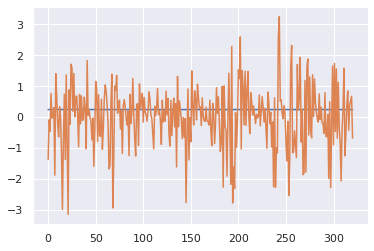

In [10]:
print("Testing the model after training.. ")
model.evaluate_model(testloader, mu_test, sigma_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test

def evaluate(testloader, mu, sigma):

    valid_targets = []
    valid_preds = []
    with torch.no_grad():
        for seq, target in testloader:
            valid_preds.append(model(seq.squeeze()))
            valid_targets += target.numpy().tolist()


     
    validRMSE = mean_squared_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
    validMAE = mean_absolute_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
    validMAPE = mean_absolute_percentage_error((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)
    validTheilU = theilU((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)

    print("MAE : {:.4f} |  MAPE  : {:.4f} |  RMSE : {:.5f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
    
    plt.plot(valid_targets)
    plt.plot(valid_preds)

### Generating table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
